In [1]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sn

from gene_variation_effects import config
from gene_variation_effects.modeling import NNPipeLine, MLP, data_shuffle_split, run_training_loop, test_model
from gene_variation_effects.modeling.utils import calculate_precision_from_conf_matrix, calculate_recall_from_conf_matrix, calculate_specificity_from_conf_matrix, generate_confusion_matrix, logits_to_prediction, generate_roc_curve, plot_roc_curve, show_confusion_matrix_heatmap

seed = 42
TARGET_GENE = "BRCA1"
df = None

2025-11-12 17:50:37.072 | INFO     | gene_variation_effects.config:<module>:11 - PROJ_ROOT path is: /Users/jeffbrin/Desktop/gene-variation-effects-ml


In [2]:
DATASET_NAME = 'BRCA1_dataset.csv'
TARGET_FEATURE = 'ClinSigSimple'
df = pd.read_csv(os.path.join(config.DATA_DIR, DATASET_NAME))


In [3]:
if df is None:
    df = pd.read_csv(os.path.join(config.DATA_DIR, f"{TARGET_GENE}.csv"))

target_array = df[TARGET_FEATURE]
df.drop(columns=[TARGET_FEATURE], inplace=True)
ONEHOT_FEATURES = ['Type']
EMBEDDED_FEATURES = []
NUMERIC_FEATURES = ['VariantLength', 'VariantLengthDifference', 'RelativeStart', "PhyloScore", "ConservationDisruption", "DistanceFromEnd", "OriginGermline"]
pipeline = NNPipeLine(df.columns, ONEHOT_FEATURES, EMBEDDED_FEATURES, NUMERIC_FEATURES)

In [4]:
# Split the data
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.3
training_data, validation_data, test_data, training_target_array, validation_target_array, test_target_array = \
    data_shuffle_split(df.to_numpy(), target_array, TEST_SIZE, VALIDATION_SIZE, seed)

In [5]:
# Fit pipeline and transform data
transformed_X_training, feature_processor = pipeline.fit_feature_transformations(training_data)
transformed_X_training = torch.Tensor(transformed_X_training)
transformed_X_validation = torch.Tensor(feature_processor.transform(validation_data))
transformed_X_test = torch.Tensor(feature_processor.transform(test_data))

training_target_array = torch.unsqueeze(torch.Tensor(training_target_array.to_numpy()), 1)
validation_target_array =  torch.unsqueeze(torch.Tensor(validation_target_array.to_numpy()), 1)
test_target_array =  torch.unsqueeze(torch.Tensor(test_target_array.to_numpy()), 1)

In [6]:
HIDDEN_SIZES = [256, 128, 64]
DROPOUT = 0
embedding_dimension_mapping = np.array([])
model = MLP(embedding_dimension_mapping, HIDDEN_SIZES, transformed_X_training.shape[1], DROPOUT)

2025-11-12 17:50:37.741 | INFO     | gene_variation_effects.modeling.train:run_training_loop:134 - Epoch 1 validation F Score=0.6383
2025-11-12 17:50:37.749 | INFO     | gene_variation_effects.modeling.train:run_training_loop:135 - Epoch 1: accuracy=0.4375
2025-11-12 17:50:37.750 | INFO     | gene_variation_effects.modeling.train:run_training_loop:136 - Epoch 1: validation accuracy=0.4688
2025-11-12 17:50:37.750 | INFO     | gene_variation_effects.modeling.train:run_training_loop:137 - Epoch 1: validation loss=1.8502
2025-11-12 17:50:37.754 | INFO     | gene_variation_effects.modeling.train:run_training_loop:134 - Epoch 2 validation F Score=0.7692
2025-11-12 17:50:37.754 | INFO     | gene_variation_effects.modeling.train:run_training_loop:135 - Epoch 2: accuracy=0.4375
2025-11-12 17:50:37.754 | INFO     | gene_variation_effects.modeling.train:run_training_loop:136 - Epoch 2: validation accuracy=0.6250
2025-11-12 17:50:37.754 | INFO     | gene_variation_effects.modeling.train:run_traini

/Users/jeffbrin/Desktop/gene-variation-effects-ml/gene_variation_effects/modeling/utils.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return matrix['Predicted Pathogenic']['True Pathogenic'] / sum(matrix.loc['True Pathogenic'])


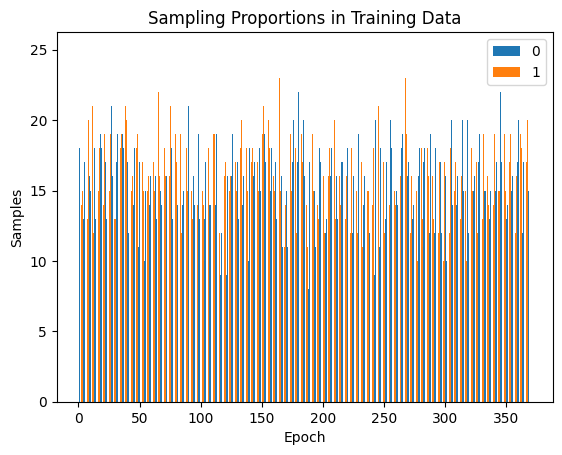

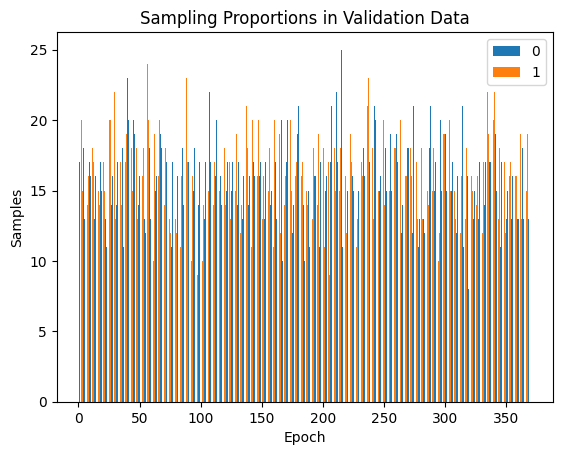

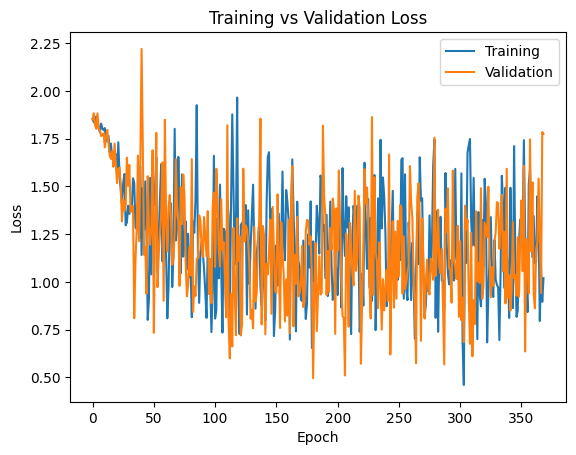

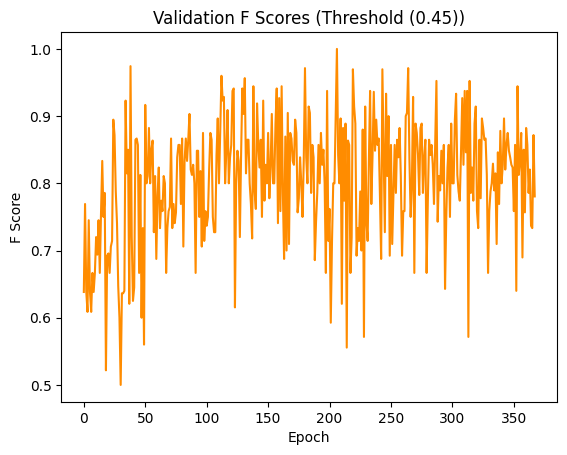

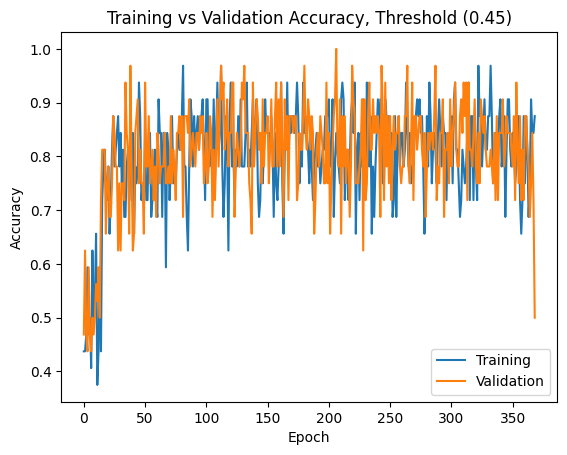

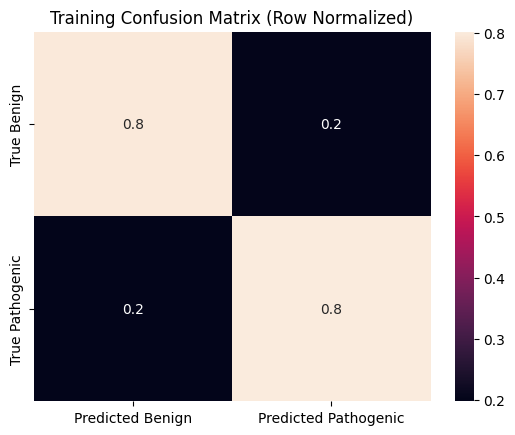

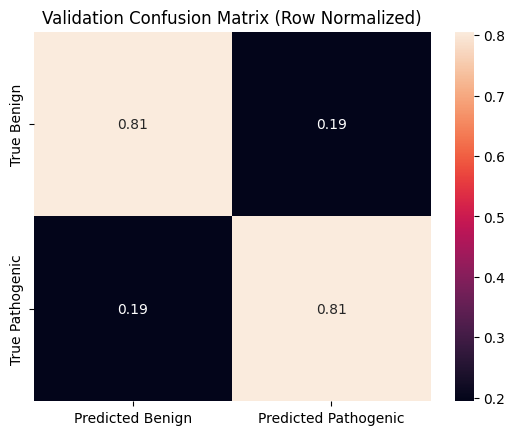

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get indices for columns using embedding
features_indices = {feat: i for i, feat in enumerate(feature_processor.get_feature_names_out())}
embedding_features_indices = [ind for feat, ind in features_indices.items() if feat.startswith('high_cardinality')]
BATCH_SIZE = 32
PATIENCE = float('inf')
PREDICTION_THRESHOLD = 0.45

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimal_model_dict, all_training_predictions_logits, all_val_predictions_logits, np.concatenate(training_y_batches), np.concatenate(val_y_batches)
optimal_model_dict, training_predictions_logits, validation_predictions_logits, training_targets, validation_targets = run_training_loop(
    model, BATCH_SIZE, transformed_X_training, transformed_X_validation, training_target_array, validation_target_array, [], [], embedding_features_indices, patience=PATIENCE, 
    positive_threshold=PREDICTION_THRESHOLD,
    optimizer=optimizer, visualize=True)
torch.save(optimal_model_dict, f"../models/{TARGET_GENE}model.pth")

training_predictions = logits_to_prediction(torch.Tensor(training_predictions_logits), PREDICTION_THRESHOLD)
validation_predictions = logits_to_prediction(torch.Tensor(validation_predictions_logits), PREDICTION_THRESHOLD)

training_confusion_matrix_df = generate_confusion_matrix(training_predictions, training_targets, normalize="true")
val_confusion_matrix_df = generate_confusion_matrix(validation_predictions, validation_targets, normalize="true")
show_confusion_matrix_heatmap(training_confusion_matrix_df, "Training")
show_confusion_matrix_heatmap(val_confusion_matrix_df, "Validation")

plot_roc_curve(generate_roc_curve(validation_predictions, validation_targets), "Validation", True)

In [8]:
# Actual pathogenic variations out of the predicted pathogenic
precision = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df['Predicted Pathogenic'])
# Proportion of actual pathogenic variants which were predicted correctly
recall = training_confusion_matrix_df['Predicted Pathogenic']['True Pathogenic'] / sum(training_confusion_matrix_df.loc['True Pathogenic'])
# Proportion of actual benign which were predicted correctly
specificity = training_confusion_matrix_df['Predicted Benign']['True Benign'] / sum(training_confusion_matrix_df.loc['True Benign'])

print(precision)
print(recall)
print(specificity)

0.7984723868726532
0.8017487808979318
0.7976454529943695


In [9]:
# Recreate the model structure
model.load_state_dict(torch.load(f"../models/{TARGET_GENE}model.pth"))

<All keys matched successfully>

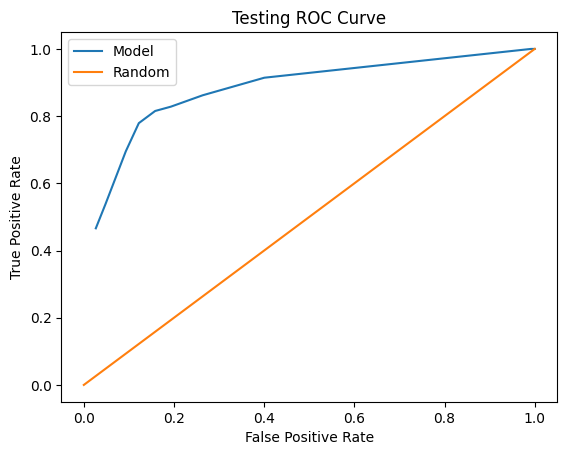

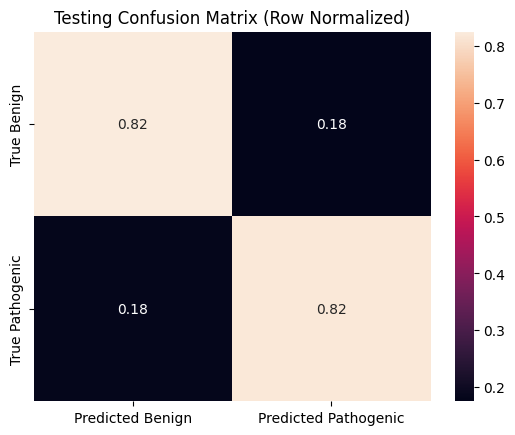

Avg Loss 0.42257730749914085
Accuracy tensor(0.8286)
F Score 0.8240806354000015


<Figure size 640x480 with 0 Axes>

In [10]:
avg_loss, accuracy, predictions, targets, f_score = test_model(model, BATCH_SIZE, transformed_X_test, test_target_array, embedding_features_indices, [])
avg_loss, accuracy

roc_curve = generate_roc_curve(predictions, targets)
plot_roc_curve(roc_curve, "Testing", show_random=True)

all_test_predictions = logits_to_prediction(torch.Tensor(predictions), PREDICTION_THRESHOLD)
test_confusion_matrix_df = generate_confusion_matrix(all_test_predictions, targets, normalize="true")
# plt.matshow(training_confusion_matrix_df)
# plt.matshow(val_confusion_matrix_df)
show_confusion_matrix_heatmap(test_confusion_matrix_df, "Testing")

print("Avg Loss", avg_loss)
print("Accuracy", accuracy)
print("F Score", f_score)